In [34]:
import os
import re
import pandas as pd
import numpy as np
import glob
import nltk
import unicodedata
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.tokenize import word_tokenize
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.svm import SVC
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import torch
import torch.nn as nn
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load data
file_path = r"../datasets/"
train_file = r"train.csv"
test_file = r"test.csv"
subm_file = r"sample_submission.csv"

train = pd.read_csv(file_path+train_file)
test = pd.read_csv(file_path+test_file)

print(train.shape)
train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [4]:
#cleaning sentences
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions (@username)
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove hashtags (#)
    tweet = re.sub(r'#', '', tweet)
    
    # Remove hashtags preceded by spaces
    tweet = re.sub(r' #', ' ', tweet)
    
    # Remove dashes (-)
    tweet = re.sub(r'-', '', tweet)
    
    # Remove special characters and punctuations (except alphanumeric and spaces)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Remove non-ASCII characters and emojis
    tweet = ''.join(char for char in tweet if char in string.printable)
    
    # Remove punctuation using Unicode categories
    tweet = ''.join(char for char in tweet if not unicodedata.category(char).startswith('P'))
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove extra whitespaces
    tweet = ' '.join(tweet.split())
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove single characters (e.g., 'a', 'b', 'c')
    tweet = re.sub(r'\b\w\b', '', tweet)
    
    # Remove multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet)
    
    # Remove the word "nan"
    tweet = re.sub(r'\bnan\b', '', tweet)

    tweet = emoji_pattern.sub(r'', tweet)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tweet = ' '.join(word for word in tweet.split() if word not in stop_words)
    
    return tweet

def get_wordnet_pos(word):
    # 将词性标签映射到WordNet词性标签
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag = {'J': wordnet.ADJ, 'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV}.get(tag, wordnet.NOUN)
    return tag

def dataset_clean(train,test):
    #Preprocessing
    train['text_clean']=train.text.apply(clean_tweet)
    test['text_clean']=test.text.apply(clean_tweet)
    
    #Lemmatization
    lemma=WordNetLemmatizer()
    train['text_lemma']=train['text_clean'].apply(lambda x: ' '.join(lemma.lemmatize(word, get_wordnet_pos(word)) for word in x.split()))
    test['text_lemma']=test['text_clean'].apply(lambda x: ' '.join(lemma.lemmatize(word, get_wordnet_pos(word)) for word in x.split()))
    
    #tokenization
    train['tokens']=train['text_lemma'].apply(lambda x: word_tokenize(x))
    test['tokens'] = test['text_lemma'].apply(lambda x: word_tokenize(x))
    
    return train, test

In [5]:
def accurarcy(y_test, y_pred):
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    print(f'F1 Score: {f1 * 100:.2f}%')
    print(f'precision: {precision * 100:.2f}%')
    print(f'recall: {recall * 100:.2f}%')
    
    report = classification_report(y_test, y_pred)
    print("Report:\n", report)

In [6]:
train,test = dataset_clean(train,test)
train.head()

,id,keyword,location,text,target,text_clean,text_lemma,tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,deed reason earthquake may allah forgive u,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,people receive wildfire evacuation order calif...,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,get sent photo ruby alaska smoke wildfire pour...,"[get, sent, photo, ruby, alaska, smoke, wildfi..."


In [7]:
corpus=pd.concat([train['tokens'],test['tokens']])
#word2vec using skip gram
w2v_model = Word2Vec(corpus,vector_size=150,window=7,min_count=2,sg=1)
w2v_model.train(corpus,total_examples=len(corpus),epochs=10)

(847307, 950780)

In [8]:
#Create document vectors by averaging word vectors. Remove out-of-vocabulary words
def get_word_embeddings(token_list,vector,k=150):
    if len(token_list) < 1:
        return np.zeros(k)
    else:
        vectorized = [vector.wv[word] if word in vector.wv else np.random.rand(k) for word in token_list] 
    
    sum = np.sum(vectorized,axis=0)
    ## return the average
    return sum/len(vectorized)     

def get_embeddings(tokens,vector):
        embeddings = tokens.apply(lambda x: get_word_embeddings(x, w2v_model))
        return list(embeddings)

In [15]:
X =get_embeddings(train['tokens'],w2v_model)
y=train.target.values
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
val_data, X_test, val_labels, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Using Naive Bayes with Word2Vec

In [16]:
#using Naive Bayes
nb_classifier = MultinomialNB()
X_train_nb = np.array(X_train)
X_test_nb = np.array(X_test)
X_train_binary = np.where(X_train_nb > 0, 1, 0)
X_test_binary = np.where(X_test_nb> 0, 1, 0)

nb_classifier.fit(X_train_binary, y_train)
y_pred_nb = nb_classifier.predict(X_test_binary)

accurarcy(y_test,y_pred_nb)

F1 Score: 73.38%
precision: 73.79%
recall: 73.21%
Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77       635
           1       0.73      0.66      0.69       507

    accuracy                           0.74      1142
   macro avg       0.74      0.73      0.73      1142
weighted avg       0.74      0.74      0.74      1142



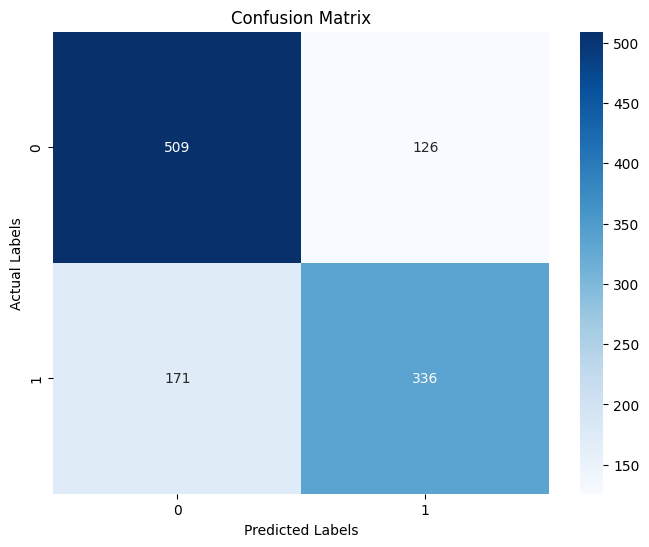

In [33]:
cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# 添加轴标签
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# 添加标题
plt.title('Confusion Matrix')


# 显示图形
# plt.show()
plt.savefig('naive_word2vec.png', dpi=500)

### Using SVM with Word2Vec

In [18]:
#using SVM
svm_model=SVC(kernel="linear", probability=True)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
accurarcy(y_test,y_pred_svm)

F1 Score: 78.29%
precision: 80.03%
recall: 77.90%
Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83       635
           1       0.83      0.67      0.74       507

    accuracy                           0.79      1142
   macro avg       0.80      0.78      0.78      1142
weighted avg       0.80      0.79      0.79      1142



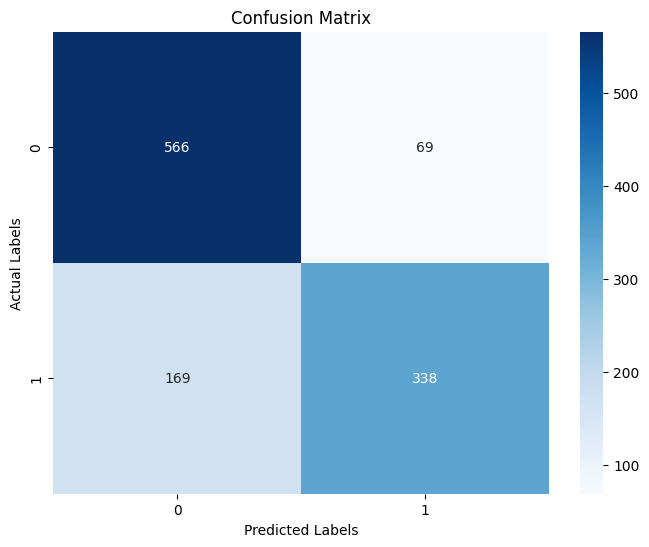

In [37]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# 添加轴标签
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# 添加标题
plt.title('Confusion Matrix')


# 显示图形
# plt.show()
plt.savefig('svm_word2vec.png', dpi=500)

### Using Logistic Regression with Word2Vec

In [19]:
#create logistic regression
lr_model=LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [20]:
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1 * 100:.2f}%')

report_lg = classification_report(y_test, y_pred)
print("Logistic Classification with Word2Vec Report:\n", report_lg)

F1 Score: 77.48%
Logistic Classification with Word2Vec Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82       635
           1       0.81      0.67      0.73       507

    accuracy                           0.78      1142
   macro avg       0.79      0.77      0.77      1142
weighted avg       0.79      0.78      0.78      1142



### Using MLP with Word2Vec

In [21]:
device = torch.device('cpu')
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(np.array(y_train, dtype=np.float32)).view(-1, 1).to(device)  # Ensure labels are float and have a 2nd dimension

X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(np.array(y_test, dtype=np.float32)).view(-1, 1).to(device)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

/tmp/ipykernel_137/1330839178.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_train_tensor = torch.FloatTensor(X_train).to(device)


In [22]:
# Define a custom MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.Sigmoid(x)
        return x

# Initialize the MLP model
input_dim = w2v_model.vector_size
hidden_dim = 128  # You can adjust the number of hidden units
output_dim = 1  # For binary classification
model = MLP(input_dim, hidden_dim, output_dim).to(device)

# Define loss and optimizer
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/jovyan/miniconda3/envs/nlp_project1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Training loop
num_epochs = 5  # Adjust the number of epochs
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
# Evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs >= 0.5).float().view(-1, 1)  # Adjust threshold for binary classification
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    # print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    predicted_binary = (outputs >= 0.5).float().view(-1, 1)
    y_test_binary = (y_test_tensor >= 0.5).float().view(-1, 1)
    accurarcy(y_test_binary,predicted_binary)

/home/jovyan/miniconda3/envs/nlp_project1/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


F1 Score: 78.47%
precision: 79.27%
recall: 78.18%
Report:
               precision    recall  f1-score   support

         0.0       0.78      0.86      0.82       635
         1.0       0.80      0.70      0.75       507

    accuracy                           0.79      1142
   macro avg       0.79      0.78      0.78      1142
weighted avg       0.79      0.79      0.79      1142



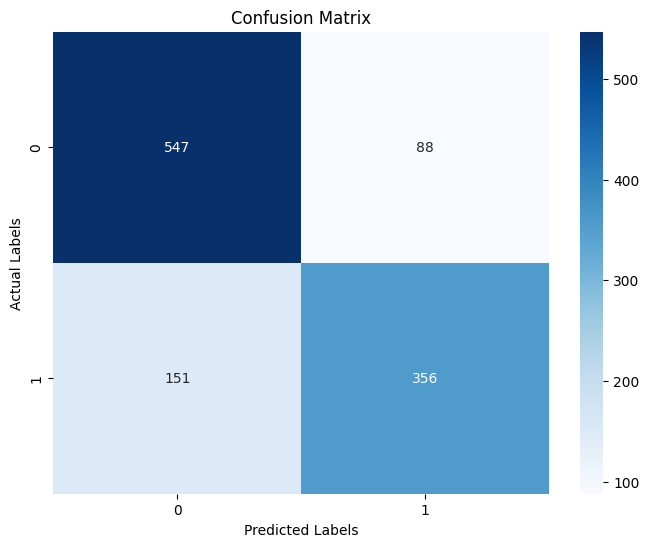

In [38]:
cm = confusion_matrix(y_test_binary, predicted_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# 添加轴标签
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# 添加标题
plt.title('Confusion Matrix')


# 显示图形
# plt.show()
plt.savefig('mlp_word2vec.png', dpi=500)